<a href="https://colab.research.google.com/github/charlieh0tel/ddf_analysis/blob/main/RecoveringPhaseDifference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

plt.rcParams["figure.figsize"] = (12,3)

In [2]:
duration = 2.
fs = 5000.
freq = 100.
samples = int(fs * duration)
#t = np.linspace(0, duration, samples, endpoint=False)
t = np.arange(samples) / fs
print(f"t={t}")

t=[0.0000e+00 2.0000e-04 4.0000e-04 ... 1.9994e+00 1.9996e+00 1.9998e+00]


In [3]:
def plot(t, signal, start=0, end=None):
  fs = 1. / (t[1] - t[0])
  n_start = int(start * fs)
  n_end = None
  if end: n_end = int(end * fs)
  t = t[n_start:n_end]
  signal = signal[n_start:n_end]
  fig, ax = plt.subplots()
  ax.plot(t, signal)
  ax.set_xlabel("time in seconds")
  ax.grid(True)

# Reference

Let x to be the reference:
$$
x[n] ≜ A_x cos(ωn + Θ_x) 
\\\\
\hat{x}[n] ≜ A_x sin(ωn + Θ_x)   
$$

In [4]:
x_i = np.cos(2.0 * np.pi * freq * t)
x_q = np.sin(2.0 * np.pi * freq * t)
#plot(t, x_i, start=0.02, end=0.2)
#plot(t, x_q, start=0.02, end=0.2)

# Signal Of Interest
Take y to be the signal of interest.  It has the same frequency as x[n] but a different phase.

$$
y[n] = A_y cos(ωn + \theta_y)
$$


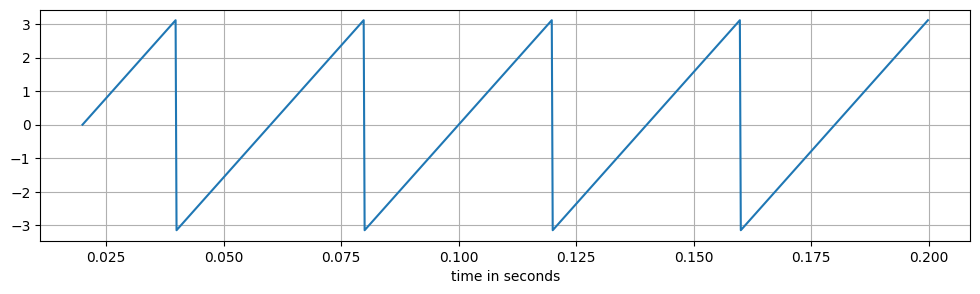

In [5]:
saw_phase = np.pi * scipy.signal.sawtooth(2 * np.pi * 25. * t)
plot(t, saw_phase, start=0.02, end=0.2)

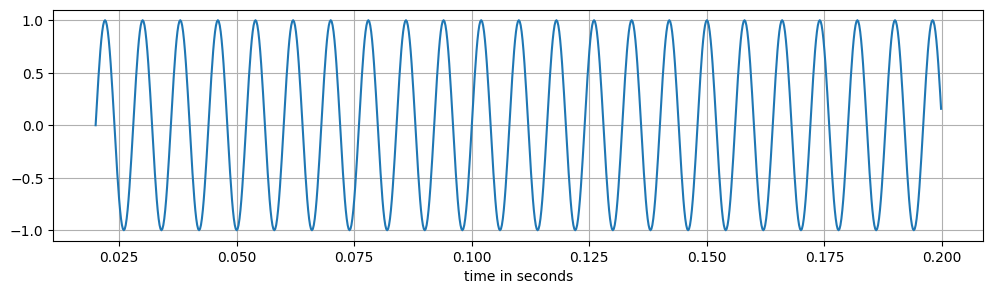

In [6]:
# Try various phase shifted signals.

# Constant phase shift.
#y = np.sin(np.unwrap(2.0 * np.pi * freq * t + 1.7))

# Phase shifted via sawtooth.
y = np.sin(np.unwrap(2.0 * np.pi * freq * t + saw_phase))

plot(t, y, start=0.02, end=0.2)

# Mixing

Multiply the signal of interest by the quadrature reference.

$$
y[n] \, x[n] = \frac{A_y A_x}{2}(cos(2ωn + θ_y + Θ_x) + cos(Θ_y - Θ_x))
\\\\
y[n] \, \hat{x}[n] = \frac{A_y A_x}{2}(sin(2ωn + θ_y + Θ_x) - sin(Θ_y - Θ_x))
$$

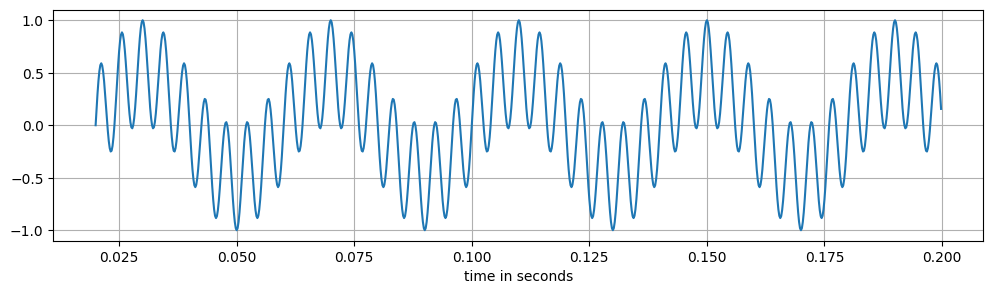

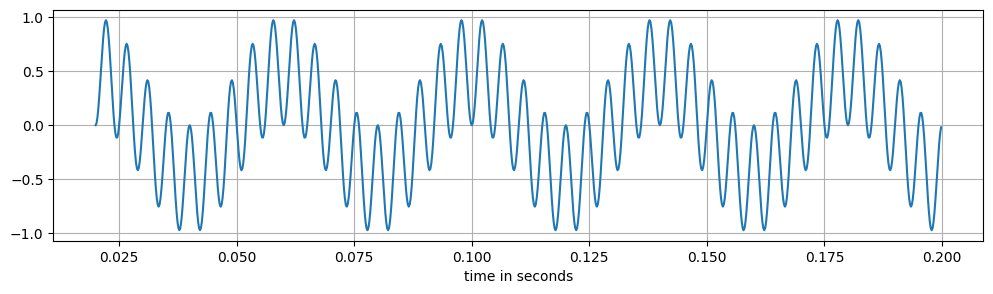

In [7]:
yx_i = y * x_i
yx_q = y * x_q

plot(t, yx_i, start=0.02, end=0.2)
plot(t, yx_q, start=0.02, end=0.2)

# Filters

In [8]:
class LowpassButterworthFilter:
  def __init__(self, cutoff_hz, fs, order):
    self.cutoff_hz = cutoff_hz
    self.fs = fs
    self.order = order
    self.sos = scipy.signal.butter(order, cutoff_hz, fs=fs, 
                                   btype='low', analog=False, output='sos')
    self.zl = scipy.signal.sosfilt_zi(self.sos)

  def __call__(self, signal):
    result, self.zl = scipy.signal.sosfilt(self.sos, signal, zi=self.zl)
    return result

  def plot_response(self):
    w, h = scipy.signal.sosfreqz(self.sos, fs=self.fs, worN=8000)
    fig, ax = plt.subplots()
    ax.plot(w, np.absolute(h))
    ax.axvline(self.cutoff_hz, color='k')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    ax.set_ylim(-0.05, 1.05)

In [9]:
class LowpassFirFilter:
  def __init__(self, cutoff_hz, fs, width_hz, ripple_db=60.):
    self.cutoff_hz = cutoff_hz
    self.fs = fs
    nyquist = fs / 2.
    width = width_hz / nyquist
    cutoff = cutoff_hz / nyquist
    n, beta = scipy.signal.kaiserord(ripple_db, width)
    self.coeffs = scipy.signal.firwin(n, cutoff, window=('kaiser', beta), pass_zero='lowpass')
    self.zl = scipy.signal.lfiltic(self.coeffs, 1.0, [], [])

  def __call__(self, data):
    result, self.zl = scipy.signal.lfilter(self.coeffs, 1.0, data, -1, self.zl)
    return result
  
  def __len__(self):
    return len(self.coeffs)
  
  def plot_coeffs(self):
    fig, ax = plt.subplots()
    ax.plot(self.coeffs)
    ax.grid(True)

  def plot_response(self):
    nyquist = self.fs / 2.0
    w, h = scipy.signal.freqz(self.coeffs, worN=8000)
    fig, ax = plt.subplots()
    ax.plot((w / np.pi) * nyquist, np.absolute(h), linewidth=2)
    ax.axvline(self.cutoff_hz, color='k')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    ax.set_ylim(-0.05, 1.05)
    


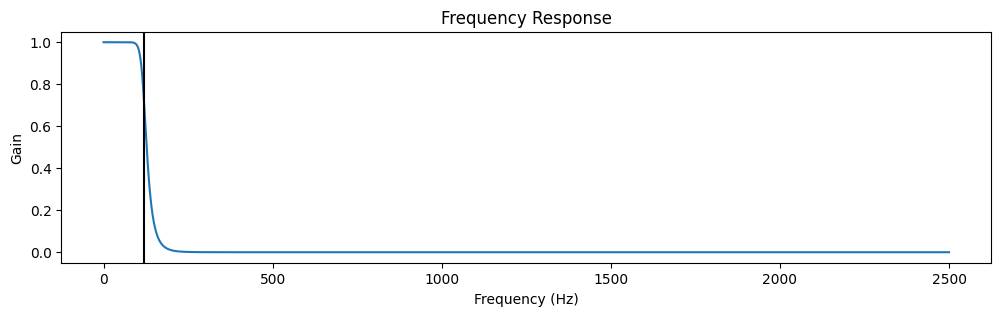

In [10]:
butter_lpf = LowpassButterworthFilter(freq * 1.2, fs, 9)
butter_lpf.plot_response()

148


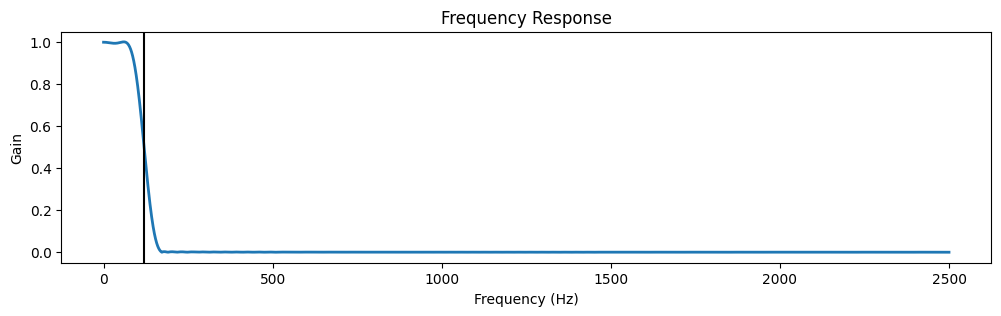

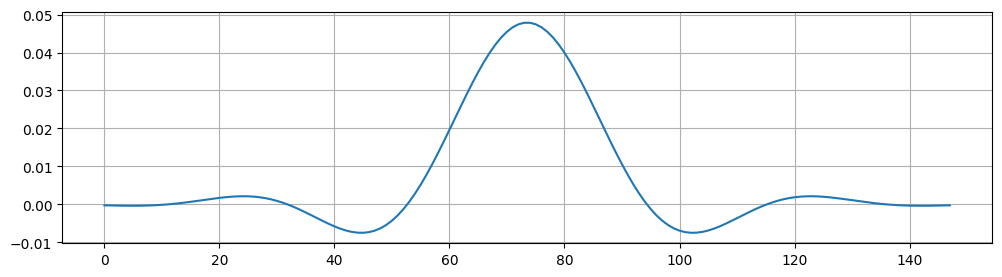

In [11]:
fir_lpf = LowpassFirFilter(freq * 1.2, fs, 100., ripple_db=50)
print(len(fir_lpf))
fir_lpf.plot_response()
fir_lpf.plot_coeffs()

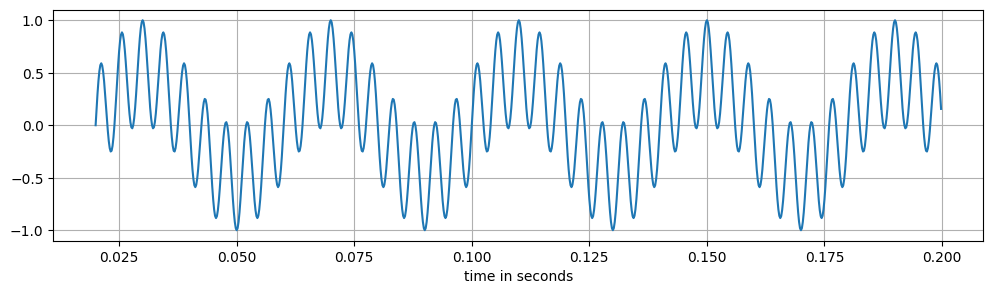

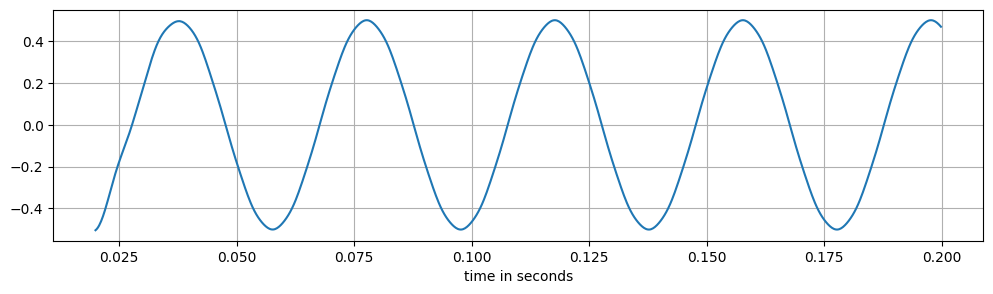

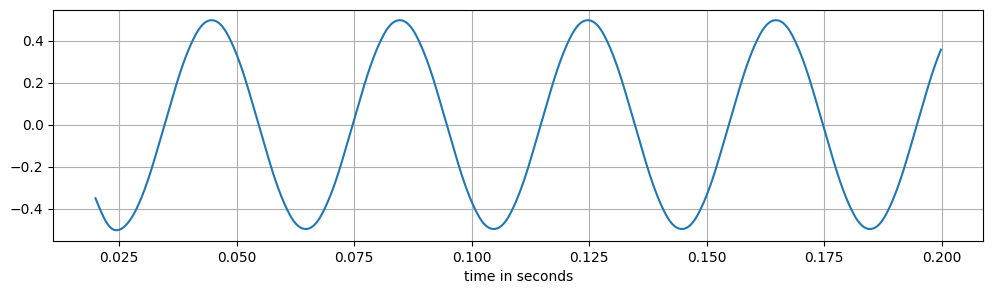

In [12]:
plot(t, yx_i, start=0.02, end=0.2)
plot(t, butter_lpf(yx_i), start=0.02, end=0.2)
plot(t, fir_lpf(yx_i), start=0.02, end=0.2)

# Phase difference

Take the mean:

$$
\overline{y[n]\, x[n]} = \frac{A_y A_x}{2}cos(Θ_y - Θ_x)
\\\\
\overline{y[n]\, \hat{x}[n]} = \frac{A_y A_x}{2}sin(Θ_y - Θ_x)
$$
Then take the angle:
$$
\begin{align}
Θ_y - Θ_x & = arg(\overline{y[n]\, x[n]} + j \; \overline{y[n]\, \hat{x}[n]})
\\\\
& = - \, arctan2(\overline{y[n]\, \hat{x}[n]},\; \overline{y[n]\, x[n]})
\end{align}
$$


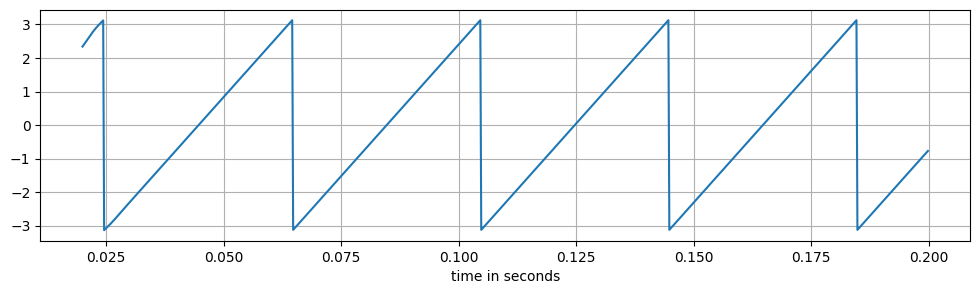

In [13]:
lpf = fir_lpf
lpf_yx_i = lpf(yx_i)
lpf_yx_q = lpf(yx_q)

recovered_phase_diff = - np.arctan2(lpf_yx_q, lpf_yx_i)

plot(t, recovered_phase_diff, start=0.02, end=0.2)